## import需要的資源

In [2]:
import pandas as pd
import numpy as np
from skimage import io
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, inception_v3, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

## 實驗4：使用InceptionV3預訓練模型

### Step1：資料預處理並進行資料擴增
#### 讀取圖片，由於InceptionV3為彩階，因此使用彩色圖片，最後訓練資料與測試資料正規化
#### 將正規化資料擴增: 旋轉角度: 10、水平位移: 0.05、垂直位移: 0.05、水平翻轉

In [8]:
# 定義train/test資料夾與標籤：man=1, woman=0
folders = [
    ('C:/Users/mrnic/.cache/kagglehub/datasets/trainingdatapro/gender-detection-and-classification-image-dataset/versions/1/train/men', 1, 'train'),
    ('C:/Users/mrnic/.cache/kagglehub/datasets/trainingdatapro/gender-detection-and-classification-image-dataset/versions/1/train/women', 0, 'train'),
    ('C:/Users/mrnic/.cache/kagglehub/datasets/trainingdatapro/gender-detection-and-classification-image-dataset/versions/1/test/men', 1, 'test'),
    ('C:/Users/mrnic/.cache/kagglehub/datasets/trainingdatapro/gender-detection-and-classification-image-dataset/versions/1/test/women', 0, 'test')
]

#x為調整照片大小,y為性別數值
X_train = []
y_train = []
X_test = []
y_test = []
# 依據資料夾設定讀取所有圖片
for folder_path, label, dataset_type in folders:
    print(f"讀取資料夾：{folder_path}，類別：{label}，類型：{dataset_type}")
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        try:
            img = cv2.imread(filepath)
            if img is not None:
                # 縮放到統一尺寸 (50x50)
                resized = cv2.resize(img, (300, 300))
                if dataset_type == 'train':
                    X_train.append(resized)
                    y_train.append(label)
                else:
                    X_test.append(resized)
                    y_test.append(label)
        except :
            continue

print(f"訓練資料數量：{len(X_train)}")
print(f"測試資料數量：{len(X_test)}")

#將輸入資料normalization，收斂到0-1間
# 轉為 NumPy 陣列與標準化
X_train = np.array(X_train).reshape(-1, 300, 300, 3) / 255.0
X_test = np.array(X_test).reshape(-1, 300, 300, 3) / 255.0
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"訓練資料數量：{len(X_train)}")
print(f"測試資料數量：{len(X_test)}")

# 資料擴增器（適用於訓練資料）
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)
val_datagen = ImageDataGenerator()  # 驗證資料不用擴增

train_generator = train_datagen.flow(X_train, y_train)
val_generator = val_datagen.flow(X_test, y_test)


讀取資料夾：C:/Users/mrnic/.cache/kagglehub/datasets/trainingdatapro/gender-detection-and-classification-image-dataset/versions/1/train/men，類別：1，類型：train
讀取資料夾：C:/Users/mrnic/.cache/kagglehub/datasets/trainingdatapro/gender-detection-and-classification-image-dataset/versions/1/train/women，類別：0，類型：train
讀取資料夾：C:/Users/mrnic/.cache/kagglehub/datasets/trainingdatapro/gender-detection-and-classification-image-dataset/versions/1/test/men，類別：1，類型：test
讀取資料夾：C:/Users/mrnic/.cache/kagglehub/datasets/trainingdatapro/gender-detection-and-classification-image-dataset/versions/1/test/women，類別：0，類型：test
訓練資料數量：220
測試資料數量：80
訓練資料數量：220
測試資料數量：80


#### 去掉頂層

In [12]:
base_model= inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(300, 300, 3))
base_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 300, 300, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 149, 149, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 149, 149, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 149, 149, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 147, 147, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 147, 147, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 147, 147, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 147, 147, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 147, 147, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 147, 147, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 73, 73, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 73, 73, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 73, 73, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 73, 73, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 71, 71, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

#### 凍結預訓練模型的權重，避免在訓練過程中更新，後面進行微調

In [15]:
base_model.trainable = False

#### 使用InceptionV3
#### GlobalAveragePooling替代 Flatten、全連接層:128，其激活函數: Relu、最後激活函數: sigmoid
#### 模型損失函數: binary_crossentropy、優化器: Adam 學習率0.001、績效: 準確度、batch size=32、epochs=50
#### EarlyStopping: 測試loss若10個回合沒有進步就停止

In [18]:
model= Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())  # 替代 Flatten，會自動平均每張 feature map
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# EarlyStopping
earlystop = EarlyStopping(
   monitor='val_loss',
    patience=10,             # 若10次驗證損失沒進步就停止
    restore_best_weights=True)

# 訓練模型
history_4 = model.fit(train_generator, batch_size=32, epochs=50, verbose=1, validation_data=val_generator, callbacks=[earlystop])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

C:\Users\mrnic\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.5292 - loss: 0.7431 - val_accuracy: 0.8000 - val_loss: 0.4817
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.7957 - loss: 0.4273 - val_accuracy: 0.8250 - val_loss: 0.3905
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.7780 - loss: 0.4304 - val_accuracy: 0.7875 - val_loss: 0.4305
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.8235 - loss: 0.3602 - val_accuracy: 0.8375 - val_loss: 0.3494
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.8777 - loss: 0.2919 - val_accuracy: 0.8000 - val_loss: 0.3916
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.8997 - loss: 0.2576 - val_accuracy: 0.8250 - val_loss: 0.3383
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.9187 - loss: 0.2216 - val_accuracy: 0.8500 - val_loss: 0.3436
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.9313 - loss: 0.2105 - val_accuracy: 0.8250 - val_loss: 0.3264
Epoch 9/

### Step3：測試集和訓練集的績效

In [24]:
# 評估訓練資料準確度
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
print(f"訓練集準確度：{train_acc:.4f}")

# 評估測試資料準確度
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"測試集準確度：{test_acc:.4f}")

訓練集準確度：0.9773
測試集準確度：0.8750


### Step4：繪製實驗4的準確度可視圖

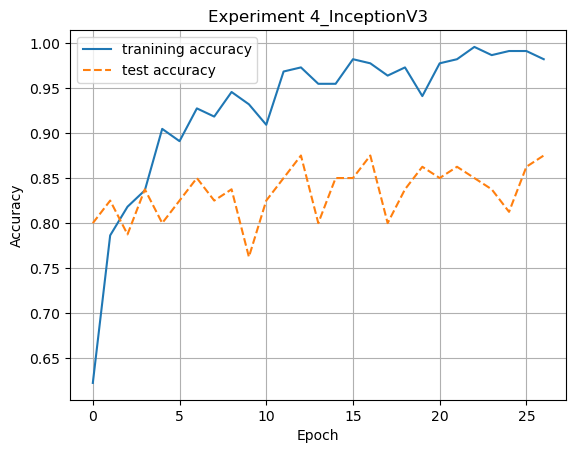

In [26]:
import matplotlib.pyplot as plt
# 繪製精準度
plt.plot(history_4.history['accuracy'], label='tranining accuracy')
plt.plot(history_4.history['val_accuracy'], '--', label='test accuracy')
plt.title('Experiment 4_InceptionV3')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### 繪製損失函數圖

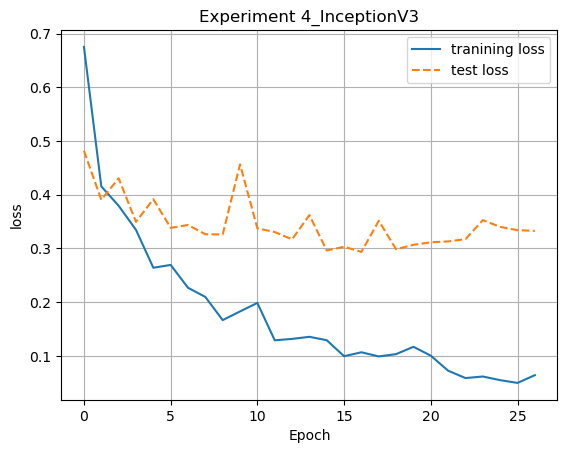

In [27]:
import matplotlib.pyplot as plt
# 繪製損失
plt.plot(history_4.history['loss'], label='tranining loss')
plt.plot(history_4.history['val_loss'], '--', label='test loss')
plt.title('Experiment 4_InceptionV3')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()